In [1]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
%matplotlib inline

In [2]:
csv_path = "mtfuji_data.csv" # ファイル名（パス）を指定する
np.set_printoptions(suppress=True) # 指数表示の禁止を設定する
fuji = np.loadtxt(csv_path, delimiter=",", skiprows=1)

In [3]:
print(fuji)

[[    0.          35.134141   139.132082     0.           0.      ]
 [    1.          35.135826   139.129202     0.         322.      ]
 [    2.          35.13751    139.126322     0.         644.      ]
 ...
 [  297.          35.631284   138.271368  1973.99     95698.      ]
 [  298.          35.632947   138.268452  1841.36     96020.      ]
 [  299.          35.63461    138.265536  1725.8      96343.      ]]


In [4]:
print(fuji.shape)

(300, 5)


左から順番に「その地点の番号」「緯度」「経度」「標高」「地点0からの距離」となっています。
標高と距離の単位はメートルです。300地点のデータです。

### 【問題1】データの可視化
Matplotlibを使い標高データを可視化してください。\
横軸に「その地点の番号」、縦軸に「標高」を設定すれば、富士山の断面図が描けます。

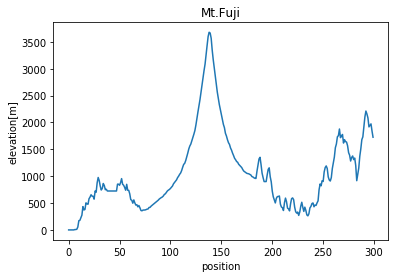

In [5]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_xlabel("position")
ax.set_ylabel("elevation[m]")
ax.set_title("Mt.Fuji")
ax.plot(fuji[:,0],fuji[:,3])
plt.show()

## 【問題2】ある地点の勾配を計算する関数を作成
「二次元配列と勾配問題」では各地点での勾配を最初に求めました。しかし、暗闇の富士山を想像すると、知ることができるのは今いる地点の勾配だけです。


「今いる地点の番号」と「今いる隣の地点の番号（今いる地点の番号-1）」の関係による勾配を求める関数を作成してください。


勾配は以下の式で求まりましたが、このデータでは「標高」がy、「その地点の番号」がxに相当します

In [6]:
location_list = fuji[:,0]
elevation_list = fuji[:,3]

In [7]:
def calc_grad(num):
    if num > 0 and num <= 299:
        dx = location_list[num] - location_list[num-1]
        dy = elevation_list[num] - elevation_list[num-1] 
        grad = dy/dx
        return grad
    else:
        print("1から299までの範囲で値を指定してください。")

## 【問題3】移動先の地点を計算する関数を作成
今いる地点の勾配の情報を元に、次に移動先の地点を計算する関数を作成してください。


数式で表すと 「移動先の地点 = 今いる地点 - 
α
 ×今いる地点の勾配」 となります。


「今いる地点の勾配」は問題2で作成した関数の返り値を使用してください。
α
 は0より大きい任意の値をとるハイパーパラメータです。機械学習の分野では学習率という名前で呼ばれます。この値によって下り方が変わります。ここでは例えば0.2に設定してください。


《実装上の注意》


上記式を計算すると移動先の地点には浮動小数点数が現れますが、今回勾配の情報を得るためには地点は整数で表す必要があります。そのため、四捨五入による変換を行ってください。また、取り得ない値となった場合の処理が必要です。例えば移動先の地点が負になると、そのようなデータが存在しないため、次に勾配が得られなくなります。


《ハイパーパラメータとは》


機械学習手法において、その手法自身では最適化が行えない値のことです。値によって手法の挙動は変化し、学習がうまくいくかどうかに影響を与えるため、設定は慎重に行う必要があります。最も単純には人間が考えて設定することになりますが、ハイパーパラメータを機械的に決めるための手法も存在します。

In [8]:
def calc_loc(num, a=0.2):
    grad = calc_grad(num)
    next_location = int(Decimal(num - a*grad).quantize(Decimal('0'), rounding=ROUND_HALF_UP))
    if next_location >= 0:
        return next_location
    else:
        print("取り得ない値です。")

### 【問題4】山を下る関数を作成
山を下る関数を作成してください。最初の地点を受け取り、問題3の関数によって地点を更新していきます\
移動毎の地点はリストなどに記録して、これを関数の返り値としてください。


最初の「今いる地点」は富士山の頂上付近、136番の地点（標高3434.59[m]）とします。ここから山を下っていきましょう。


《実装上の注意》


問題3で四捨五入を行っているため、移動先の地点が今いる地点と同じ場合になることがあります。\
移動量が減ってきたということなので、その時点で山を下りきったと判断してください。\
実際の勾配降下法ではこのようなことは起きません。

In [9]:
def descent_mountain(position=136, a=0.2):
    present_loc = [position]
    for counter in range(position): #ループ回数は上限をpositionとする。
        next_loc = calc_loc(position, a)
        present_loc.append(next_loc)
        position = next_loc
        if present_loc[-1] == present_loc[-2]: # defを抜けるために、present_locの前後で判定する方法しか思いつきませんでした。
            del present_loc[-1] #リストに同値が格納されてしまうため、最後の値を削除しています。
            break
    return present_loc

In [10]:
present_loc = descent_mountain(136)
print(present_loc)

[136, 102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75]


### 【問題5】下山過程の可視化
問題4における下山過程をMatplotlibを使いグラフで可視化してください。


《可視化例》


断面図の中に移動した地点を点で表示する
繰り返し毎の標高や勾配を折れ線グラフにする

In [11]:
present_elevation = [elevation_list[i] for i in present_loc]
print(present_loc)
print(present_elevation)

[136, 102, 98, 95, 93, 89, 85, 82, 79, 73, 70, 78, 77, 75]
[3434.59, 817.62, 741.17, 672.36, 631.71, 575.07, 505.1, 458.66, 418.41, 368.91, 412.27, 390.14, 386.64, 371.19]


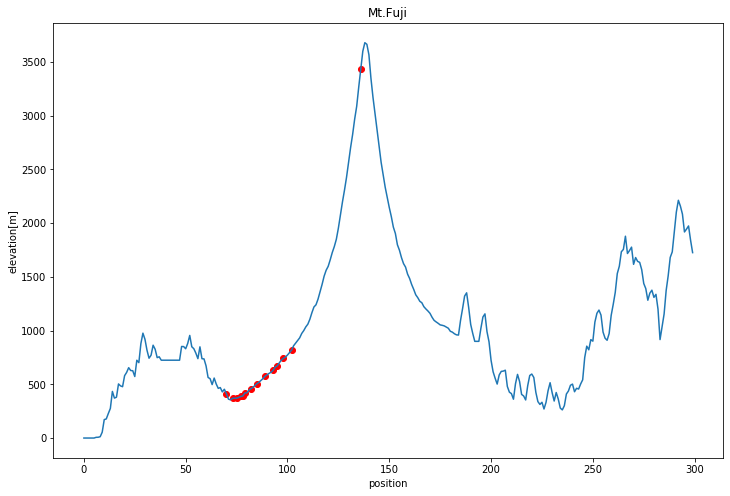

In [12]:
plt.figure(figsize=(12, 8))

plt.title("Mt.Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")

plt.plot(fuji[:,0],fuji[:,3])
plt.scatter(present_loc, present_elevation, c='r')

plt.show()

### 【問題6】初期値の変更
問題4では最初の「今いる地点」を136としましたが、これを他の全ての点で計算してください。\
そして、いくつかの初期値に対してどのような下山過程となるか、問題5のように可視化してください。\
機械学習においては 初期値 をどう設定するかが結果に影響を与えることが確認できます。


《初期値とは》


今回の例での最初の地点のような値を初期値と呼びます。これを変更すると結果が変化します。\
例えば136と142では富士山の異なるの斜面を下ることになります。

- 初期値：142

In [13]:
present_loc = descent_mountain(142)
print(present_loc)

[142, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169, 173, 176, 177, 178, 180, 186, 164, 169]


In [14]:
present_elevation = [elevation_list[i] for i in present_loc]
print(present_elevation)

[3171.53, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.33, 1043.91, 1033.52, 993.63, 1203.92, 1306.46, 1182.32, 1081.07, 1049.

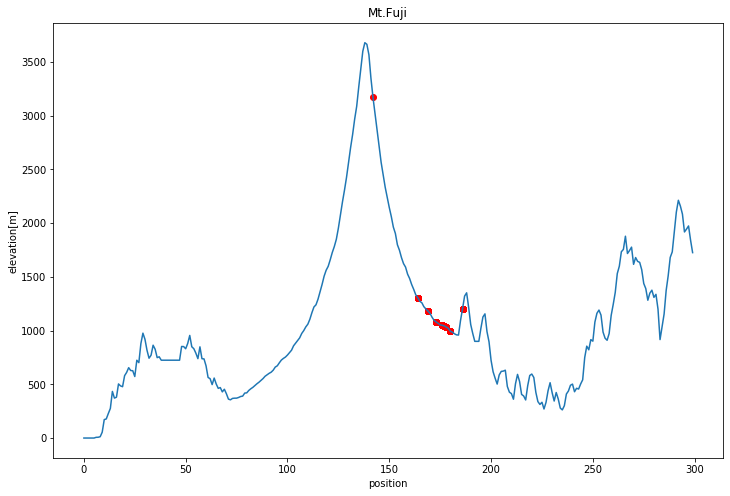

In [15]:
plt.figure(figsize=(12, 8))

plt.title("Mt.Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")

plt.plot(fuji[:,0],fuji[:,3])
plt.scatter(present_loc, present_elevation, c='r')

plt.show()

- 初期値：266

In [16]:
present_loc = descent_mountain(266)
print(present_loc)

[266, 241, 255, 287, 259, 225, 221, 227, 215, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247, 226, 239, 228, 206, 205, 198, 231, 247,

In [17]:
present_elevation = [elevation_list[i] for i in present_loc]
print(present_elevation)

[1878.56, 430.96, 986.58, 1510.22, 1141.8, 332.88, 563.7, 332.39, 405.96, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23, 990.05, 344.44, 855.15, 270.33, 491.04, 440.61, 622.89, 620.23

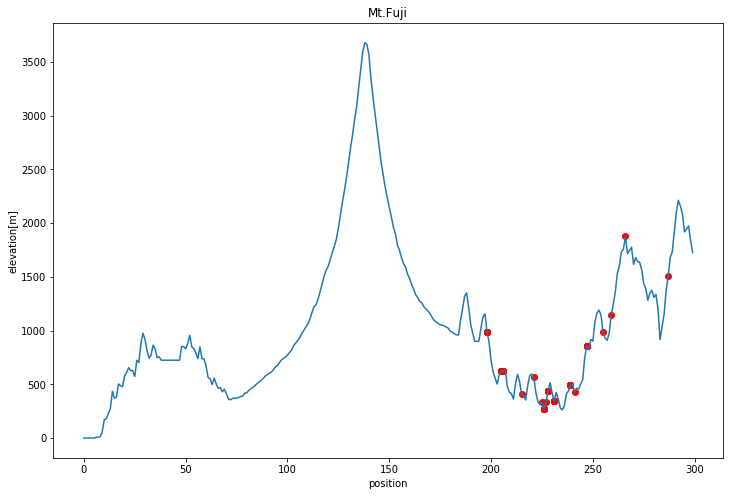

In [18]:
plt.figure(figsize=(12, 8))

plt.title("Mt.Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")

plt.plot(fuji[:,0],fuji[:,3])
plt.scatter(present_loc, present_elevation, c='r')

plt.show()

### 【問題7】（アドバンス問題）ハイパーパラメータの変更

ハイパーパラメータ $\alpha$ を変化させるとどのような下山過程となるか、問題5のように可視化してください。\
そして、ハイパーパラメータにより結果が大きく異なることを確認してください。

- 初期値：136、ハイパーパラメータ𝛼：0.1

In [19]:
ALPHA = 0.1

present_loc = descent_mountain(136, ALPHA)
print(present_loc)

present_elevation = [elevation_list[i] for i in present_loc]
print(present_elevation)

[136, 119, 113, 108, 105, 102, 100, 98, 96, 93, 91, 90, 89, 87, 85, 83, 82, 80]
[3434.59, 1561.94, 1219.86, 1000.24, 910.5, 817.62, 772.58, 741.17, 700.15, 631.71, 602.36, 588.99, 575.07, 536.54, 505.1, 471.82, 458.66, 420.6]


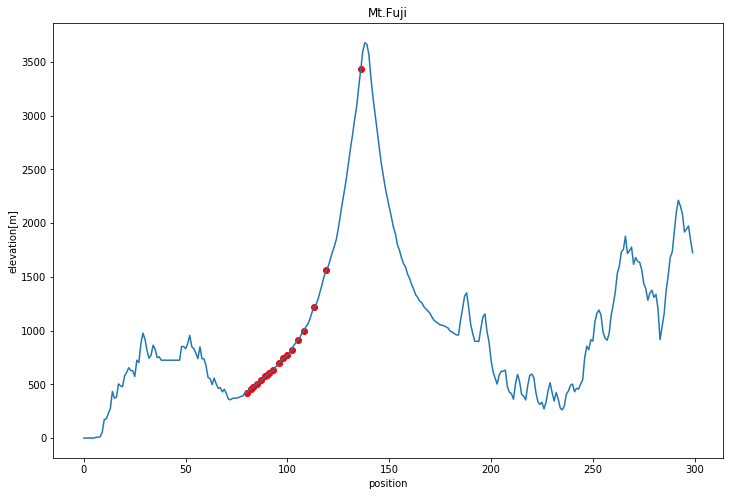

In [20]:
plt.figure(figsize=(12, 8))

plt.title("Mt.Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")

plt.plot(fuji[:,0],fuji[:,3])
plt.scatter(present_loc, present_elevation, c='r')

plt.show()

- 初期値：142、ハイパーパラメータ𝛼：0.1

In [21]:
ALPHA = 0.1

present_loc = descent_mountain(142, ALPHA)
print(present_loc)

present_elevation = [elevation_list[i] for i in present_loc]
print(present_elevation)

[142, 160, 164, 167, 171, 175, 176]
[3171.53, 1484.72, 1306.46, 1222.48, 1124.83, 1053.28, 1049.33]


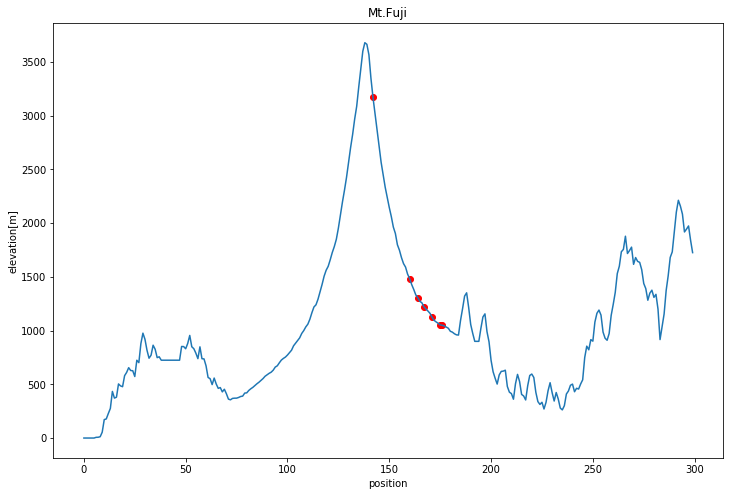

In [22]:
plt.figure(figsize=(12, 8))

plt.title("Mt.Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")

plt.plot(fuji[:,0],fuji[:,3])
plt.scatter(present_loc, present_elevation, c='r')

plt.show()

- 初期値：136、ハイパーパラメータ𝛼：0.4

In [23]:
ALPHA = 0.4

present_loc = descent_mountain(136, ALPHA)
print(present_loc)

present_elevation = [elevation_list[i] for i in present_loc]
print(present_elevation)

[136, 69, 59, 60, 86, 80, 79, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84, 77, 73, 68, 84]
[3434.59, 454.21, 736.48, 672.24, 519.54, 420.6, 418.41, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64, 368.91, 429.49, 488.4, 386.64

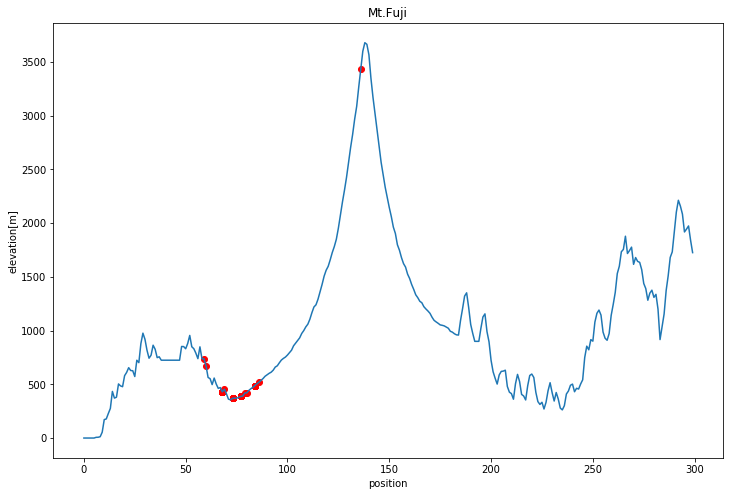

In [24]:
plt.figure(figsize=(12, 8))

plt.title("Mt.Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")

plt.plot(fuji[:,0],fuji[:,3])
plt.scatter(present_loc, present_elevation, c='r')

plt.show()

- 初期値：142、ハイパーパラメータ𝛼：0.4

In [25]:
ALPHA = 0.4

present_loc = descent_mountain(142, ALPHA)
print(present_loc)

present_elevation = [elevation_list[i] for i in present_loc]
print(present_elevation)

[142, 213, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178, 182, 188, 176, 178]
[3171.53, 592.32, 1033.52, 970.58, 1351.64, 1049.33, 1033.52, 970.58, 1351.64, 1049.33, 1033.52, 970.58, 1351.64, 1049.33, 1033.52, 970.58, 1351.64, 1049.33, 1033.52, 970.58, 1351.64, 1049.33, 1033.52, 970.58, 1351.64, 1049.33, 1033.52, 970.58, 1351.64, 1049.33, 1033.52, 970.58, 1351

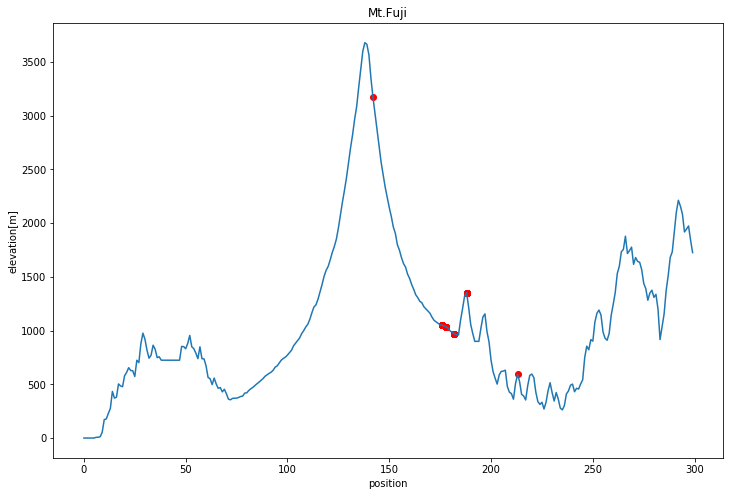

In [26]:
plt.figure(figsize=(12, 8))

plt.title("Mt.Fuji")
plt.xlabel("position")
plt.ylabel("elevation[m]")

plt.plot(fuji[:,0],fuji[:,3])
plt.scatter(present_loc, present_elevation, c='r')

plt.show()